In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import DMatrix, XGBRegressor

In [3]:
import tensorflow as tf

In [4]:
df = pd.read_csv(r'C:\Users\gabri\VSCode Projects\Assessments\eSure\health_insurance.csv')

In [5]:
# OBJECTIVES
# new customers need to fill out a form with their information that will dictate their health insurance premium
# details include the customer's 'age', 'sex', 'bmi', 'smoker' and 'region'
# attributes believed to be carrying the highest risk from high to low: smoking, bmi, age, region and sex
# create a model that quanitifies as a fraction of 1, each contribution to the cost of the claim
# princing and risk go hand-in-hand, but good to have a risk level as well even though this is reflected in the charges
# create a model takes input and outputs a premium based on the customer's risk profile
# build and deploy the simplest model to predict a premium 

EXPLORATORY DATA ANALYSIS

In [6]:
# DATA EXPLORATION
fig = sp.make_subplots(rows=1, cols=4, subplot_titles=("Age", "BMI", "Children", "Charges"))
fig.add_trace(go.Histogram(x=df['age'], name='Age'), row=1, col=1)
fig.add_trace(go.Histogram(x=df['bmi'], name='BMI'), row=1, col=2)
fig.add_trace(go.Histogram(x=df['children'], name='Children'), row=1, col=3)
fig.add_trace(go.Histogram(x=df['charges'], name='Charges'), row=1, col=4)
fig.update_layout(title_text="Histogram Subplot", showlegend=False)

DATA PREPROCESSING 

In [7]:
categorical_columns = ['sex', 'region', 'smoker']
# ONE-HOT ENCODING IN PANDAS
# df_encoded = pd.get_dummies(df, columns=categorical_columns)
# LABEL ENCODE WITH SKLEARN LABEL ENCODER
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

FEATURE SELECTION

In [8]:
# FEATURE SELECTION
from sklearn.model_selection import train_test_split
# feature importance, correlation analysis 
X, y = df.drop(['charges'], axis=1).to_numpy(), df['charges'].to_numpy()
print(f'Number of features: {X.shape[1]}')
print(f'Number of records: {X.shape[0]}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Length of X_train: {X_train.shape[0]}')
print(f'Length of y_train: {y_train.shape[0]}')

print(f'Length of X_test: {X_test.shape[0]}')
print(f'Length of y_test: {y_test.shape[0]}')

# dtrain = DMatrix(X_train, label=y_train)
# dtest = DMatrix(X_test, label=y_test)

Number of features: 6
Number of records: 1338
Length of X_train: 896
Length of y_train: 896
Length of X_test: 442
Length of y_test: 442


In [9]:
# MODEL SELECTION AND TRAINING
class Model:
    def __init__(self, model):
        self.model = model

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def mae(self, y_test, y_pred):
        return round(mean_absolute_error(y_test, y_pred), 0)
    
    def rmse(self, y_test, y_pred):
        return round(sqrt(mean_squared_error(y_test, y_pred)), 0)
    

linear_model = Model(model=LinearRegression())
linear_model.train(X_train, y_train)

rf_model = Model(model=RandomForestRegressor())
rf_model.train(X_train, y_train)

xgboost_model = Model(model=XGBRegressor())
xgboost_model.train(X_train, y_train)

linear_mae = linear_model.mae(y_test, linear_model.predict(X_test))
linear_rmse = linear_model.rmse(y_test, linear_model.predict(X_test))
rf_mae = rf_model.mae(y_test, rf_model.predict(X_test))
rf_rmse = rf_model.rmse(y_test, rf_model.predict(X_test))
xgboost_mae = xgboost_model.mae(y_test, xgboost_model.predict(X_test))
xgboost_rmse = xgboost_model.rmse(y_test, xgboost_model.predict(X_test))

performance = pd.DataFrame(
    {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [linear_mae, rf_mae, xgboost_mae],
    'RMSE': [linear_rmse, rf_rmse, xgboost_rmse]
    }
)
performance

,Model,MAE,RMSE
0,Linear Regression,4204.0,5927.0
1,Random Forest,2570.0,4728.0
2,XGBoost,2878.0,5104.0


MODEL REFINEMENT

In [10]:
from sklearn.model_selection import GridSearchCV

class Model:
    def __init__(self, model, hyperparameters=None):
        self.model = model
        self.hyperparameters = hyperparameters
        self.best_model = None

    def train(self, X_train, y_train, cv=5):
        if self.hyperparameters is not None:
            grid_search = GridSearchCV(self.model, self.hyperparameters, scoring='neg_mean_absolute_error', cv=cv)
            grid_search.fit(X_train, y_train)
            self.best_model = grid_search.best_estimator_
        else:
            self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.best_model:
            return self.best_model.predict(X_test)   
        else:
            return self.model.predict(X_test)

    def mae(self, y_test, y_pred):
        return round(mean_absolute_error(y_test, y_pred), 0)
    
    def rmse(self, y_test, y_pred):
        return round(sqrt(mean_squared_error(y_test, y_pred)), 0)

In [11]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10], 'min_samples_split': [2], 
              'min_samples_leaf': [1], 'max_features': ["auto", "sqrt", "log2"]}

rf_tuned_model = Model(model=RandomForestRegressor(), hyperparameters=param_grid)
rf_tuned_model.train(X_train, y_train)
y_pred = rf_tuned_model.predict(X_test)
rf_tuned_mae = round(mean_absolute_error(y_pred, y_test), 0)
rf_tuned_rmse = round(sqrt(mean_squared_error(y_test, y_pred)), 0)

c:\Users\gabri\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gabri\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gabri\miniconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\gabri\miniconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\gabri\miniconda3\Lib\site-pac

In [12]:
param_grid = {'objective': ['reg:squarederror'], 'max_depth': [3, 4, 5], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [100, 200, 300]}

xgb_tuned_model = Model(model=XGBRegressor(), hyperparameters=param_grid)
xgb_tuned_model.train(X_train, y_train)
y_pred = xgb_tuned_model.predict(X_test)
xgb_tuned_mae = round(mean_absolute_error(y_pred, y_test), 0)
xgb_tuned_rmse = round(sqrt(mean_squared_error(y_test, y_pred)), 0)

In [13]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),        
    keras.layers.Dense(8, activation='relu'), 
    keras.layers.Dense(1)  
])

custom_learning_rate = 0.005  # Replace with your desired learning rate
custom_optimizer = keras.optimizers.Adam(learning_rate=custom_learning_rate)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, epochs=30, batch_size=2, validation_split=0.2, verbose=False)

nn_mae = mean_absolute_error(y_test, model.predict(X_test))
nn_rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))

14/14 [==============================] - 0s 935us/step


In [14]:
model_list = ['Linear Regression', 'Random Forest', 'XGBoost', 'Tuned Random Forest', 'Tuned XGBoost', 'Neural Network']
mae_list = [linear_mae, rf_mae, xgboost_mae, rf_tuned_mae, xgb_tuned_mae, nn_mae]
rmse_list = [linear_rmse, rf_rmse, xgboost_rmse, rf_tuned_rmse, xgb_tuned_rmse, nn_rmse]
performance = pd.DataFrame(
    {
    'Model': model_list,
    'MAE': mae_list,
    'RMSE': rmse_list
    }
)


lowest_mae_model = performance.loc[performance['MAE'].idxmin()]['Model']
lowest_rmse_model = performance.loc[performance['RMSE'].idxmin()]['Model']
print(f'Lowest MAE Model: {lowest_mae_model}')
print(f'Lowest RMSE Model: {lowest_rmse_model}')
performance

Lowest MAE Model: Tuned XGBoost
Lowest RMSE Model: Tuned XGBoost


,Model,MAE,RMSE
0,Linear Regression,4204.000000,5927.000000
1,Random Forest,2570.000000,4728.000000
2,XGBoost,2878.000000,5104.000000
3,Tuned Random Forest,2830.000000,4782.000000
4,Tuned XGBoost,2500.000000,4408.000000
5,Neural Network,8620.923132,11344.244822


In [15]:
# xgb_tuned_model.predict(np.array([20, 0, 20, 0, 0, 1]).reshape(1, 6))

MODEL VALIDATION 

MODEL DEPLOYMENT 

MODEL MONITORING 

MAXIMISE PROFITS

In [16]:
# FACTS AND FIGURES
# In the United States, fraudulent claims cost $40 billion annually while in the UK 350 cases of insurance fraud are uncovered every day.
# AI algorithms can identify likely fraudulent claims and highlight them for further investigation and action by humans if necessary
# Progressive’s in-car monitoring system that if installed gives the driver a discount on premiums
# feeding the driving data to the algorithms or data from wearable devices that monitor activity levels and heart rate

In [17]:
# # HOW TO IMPROVE PROFITABILITY

# INCREASE CUSTOMER SATISFACTION - CUSTOMER INCENTRIVES
# Captricity:  extract handwritten and typed forms into a digital form with a 99.9% accuracy, it has been driving revenue by reducing cycle times and improving data quality for
# Zendrive: Would you install an app on your phone that monitors your driving behavior - significant discount on your car insurance premium. The algorithms turn the sensor data it collects into safety reminders and therefore reducing
# Cape Analytics: By building comprehensive property attributes through computer vision and geospatial imagery,

# IMPROVE FRAUD DETECTION

# MAXIMISE PROFIT BY IMPROVING UNDERWRITING (BETTER RISK ASSESSMENT) 

# MAXIMISE PROFIT BY IMPROVING PRICING SOPHISTICATION

# descriptive, predictive, and prescriptive MODELS

DATA SOURCES

In [18]:
# https://www.mckinsey.com/industries/financial-services/our-insights/how-data-and-analytics-are-redefining-excellence-in-p-and-c-underwriting

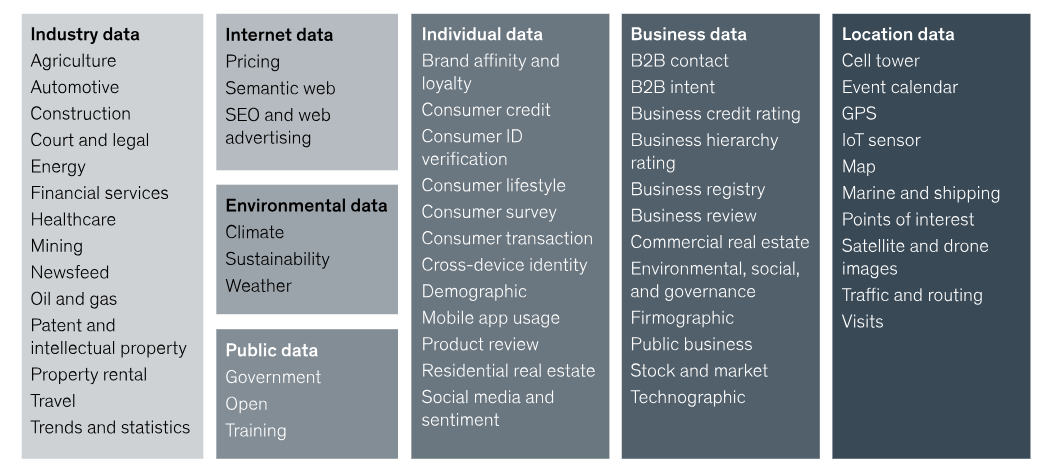